## Dataset creation


In [1]:
import tensorflow as tf
import numpy as np
import dlib
import cv2
import os
from imutils import face_utils
import matplotlib.pyplot as plt
import albumentations as A
IMAGE_SIZE = 192


In [14]:
def create_dataset(dataset_path='../data/raw/', maxi = np.Infinity):
    images = []
    keypoints = []

    p = "../shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)
    directory = os.fsencode(dataset_path)

    co = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        image = cv2.imread(dataset_path + filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for (_, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            res_factor = IMAGE_SIZE / image.shape[0]
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE),
                               interpolation=cv2.INTER_AREA)
            shape = shape * res_factor
            images.append(image)
            keypoints.append(shape)
            break
        co+=1
        if co > maxi: break
    images = np.ndarray(images, dtype=np.uint8)
    # here uint8 seems enough, but what if some values go negative? 
    keypoints = np.ndarray(keypoints, dtype=np.int16)
    return images, keypoints

def create_dataset_with_detector(dataset_path='../data/raw/', maxi = np.Infinity):
    images = np.empty([0, IMAGE_SIZE, IMAGE_SIZE, 3], dtype=np.uint8)
    keypoints = np.empty([0, 68, 2], dtype=np.uint8)
    
    p = "../shape_predictor_68_face_landmarks.dat"
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)
    directory = os.fsencode(dataset_path)

    co = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        image = cv2.imread(dataset_path + filename, )

        # border
        row, col = image.shape[:2]
        bottom = image[row-2:row, 0:col]
        mean = cv2.mean(bottom)[0]

        bordersize = int(image.shape[0] * 0.25)
        image = cv2.copyMakeBorder(
            image,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[mean, mean, mean]
        )

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        # face detector
        # yeah, I'll just ignore exceptions
        try:
            for (x, y, w, h) in faces:
               image = image[x-bordersize:x+bordersize+w,
                             y-bordersize:y+bordersize+h]

            # keypoint detection
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 0)

            for (_, rect) in enumerate(rects):
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                res_factor = IMAGE_SIZE / image.shape[0]
                image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE),
                                interpolation=cv2.INTER_AREA)
                shape = shape * res_factor
                image = np.expand_dims(image, axis=0)
                images = np.append(images, image, axis = 0)

                shape = np.expand_dims(shape, axis=0)
                keypoints = np.append(keypoints, shape, axis=0)
                break
            co+=1
            if co > maxi: break
        except Exception:
            continue
    images = np.array(images, dtype=np.uint8)
    keypoints = np.array(keypoints, dtype=np.uint8)
    return images, keypoints


def augment(images, keypoints):
    t_images = []
    t_keypoints = []
    transform = A.Compose(
        [A.Rotate(p=0.5, limit=15),
         A.HorizontalFlip(p=0.5),
         A.ImageCompression(quality_lower=35, quality_upper=100, p=0.75),
         A.GaussianBlur(blur_limit=(3, 9), sigma_limit=0, p=0.5)
         ],
        keypoint_params=A.KeypointParams(format='xy')
    )
    e_count = 0
    total = 0
    for (im, kp) in zip(images, keypoints):
        # Lord forgive me...
        try:
            transformed = transform(image=im, keypoints=kp)
            if len(transformed['keypoints']) != 68: continue
            t_keypoints.append(transformed['keypoints'])
            t_images.append(transformed['image'])
        except Exception:
            e_count += 1
        finally:
            total += 1
            continue
    print(f'Encountered exceptions in {e_count/total}% of images')
    
    # No memory bruh
    # t_images = np.array(t_images, dtype=np.float32) / 255
    # t_keypoints = np.array(t_keypoints, dtype=np.float32) / IMAGE_SIZE

    return t_images, t_keypoints
    

def split_dataset(X, Y, test_ratio=0.20):
    size = int(len(X) * test_ratio)
    return X[size:], X[:size], Y[size:], Y[:size]

def compress_splits(X, Y, dir):
    np.savez_compressed(dir + 'Xvalues.npz', X)
    np.savez_compressed(dir + 'Yvalues.npz', Y)


def uncompress_splits(dir):
    X = np.load(dir + 'Xvalues.npz')['arr_0']
    Y = np.load(dir + 'Yvalues.npz')['arr_0']

    return X,Y

def to_tensor(X,Y):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    return X,Y

## Dataset prep 

In [15]:
# If need to create a new one
images, keypoints = create_dataset()
compress_splits(images, keypoints, '../data/raw_compressed_nd/')

KeyboardInterrupt: 

In [136]:
# Load
images, keypoints = uncompress_splits('../data/raw_compressed/')

In [137]:
# Augmentation
images, keypoints = augment(images, keypoints)
# images = np.array(images, dtype=np.float32) / 255
images = np.array(images, dtype = np.uint8)
# keypoints = np.array(keypoints, dtype=np.float32) / IMAGE_SIZE
keypoints = np.array(keypoints, dtype=np.uint8)
compress_splits(images, keypoints, '../data/processed_compressed/')

Encountered exceptions in 0.0047115056333219526% of images


In [ ]:
# free some memory
trainx, testx, trainy, testy = split_dataset(images, keypoints)
del images
del keypoints

In [ ]:
# If already exists
images, keypoints = uncompress_splits('../data/processed_compressed')
trainx, testx, trainy, testy = split_dataset(images, keypoints)
del images
del keypoints

## Model training and inference

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras import backend as K


def build(size):
   input_shape = (size, size, 3)   
   model = Sequential()
   model.add(Conv2D(32, (5, 5), padding='same',
                    input_shape=input_shape))
   model.add(BatchNormalization(input_shape=input_shape))
   model.add(Activation('relu'))
   model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

   model.add(Conv2D(64, (5, 5)))
   model.add(BatchNormalization(input_shape=input_shape))
   model.add(Activation('relu'))
   model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2), padding='valid'))

   model.add(Conv2D(48, (5, 5)))
   model.add(BatchNormalization(input_shape=input_shape))
   model.add(Activation('relu'))
   model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2), padding='valid'))

   model.add(Conv2D(64, (3, 3)))
   model.add(BatchNormalization(input_shape=input_shape))
   model.add(Activation('relu'))
   model.add(MaxPooling2D(pool_size=(2, 2),
                          strides=(2, 2), padding='valid'))

   model.add(Conv2D(128, (3, 3)))
   model.add(BatchNormalization(input_shape=input_shape))
   model.add(Activation('relu'))
   model.add(GlobalAveragePooling2D())

   model.add(Dense(500, activation='relu'))
   model.add(Dense(136))
   return model


In [7]:
model = get_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 batch_normalization_6 (Batc  (None, 60, 60, 64)      

In [16]:
def get_model():
    model = build(IMAGE_SIZE)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    return model

def load_model(path):
    model = tf.keras.models.load_model(path)
    return model

def evaluate_model(model, x, y):
    loss, acc = model.evaluate(x, y, verbose=2)
    print(f'Model, accuracy: {acc*100:5.2f}%')

def save_model(model, path):
    model.save(path)


In [12]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    save_frequency = 5*82)

model.fit(trainx, 
          trainy,
          epochs=200,
          steps_per_epoch=50,
          batch_size=50,
          validation_data=(testx, testy),
          shuffle=True,
          callbacks=[cp_callback])



81/81 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.4640
Epoch 1: val_loss improved from inf to 0.01289, saving model to training\cp-0001.ckpt
81/81 [==============================] - 68s 812ms/step - loss: 0.0414 - accuracy: 0.4640 - val_loss: 0.0129 - val_accuracy: 0.5785


In [17]:
model = load_model('../model.h5')

In [18]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

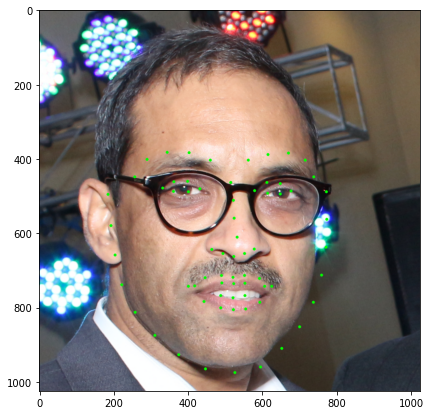

In [27]:
def predictor(model, image_path: str, path:str = '../ehe.jpg'):
    size = model.input_shape[1]
    # load
    image = cv2.imread(image_path)

    # resize
    res_factor_x = size / image.shape[0]
    res_factor_y = size / image.shape[1]

    input_image = cv2.resize(image, (size, size),
                       interpolation=cv2.INTER_AREA) / 255
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32) 
    input_image = tf.expand_dims(input_image, axis=0)

    # predict
    res = model(input_image)[0].numpy() * 192

    # visualize
    for (x,y) in res:
        image = cv2.circle(image, (int(x/res_factor_x), int(y/res_factor_y)), 1, (0, 255, 0), 5)

    # save
    return image


im = predictor(model, '../data/raw/00052.png')
plt.figure(figsize = (7,7))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [29]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")

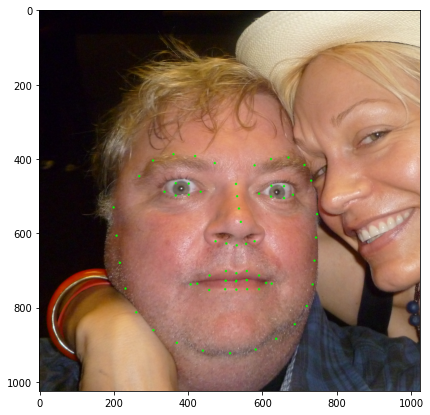

In [31]:
def dlib_reference(image, detector, predictor, save_path=None):
    """Runs prediction on a single image using DLib predictor"""

    image = cv2.imread(image)
    gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(image=gray, box=face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(img=image, center=(x, y), radius=3,
                       color=(0, 255, 0), thickness=-1)

    if save_path is not None:
        cv2.imwrite(save_path, image)
        return
    return image


im = dlib_reference('../data/raw/00044.png', detector, predictor)
plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))


In [6]:
# latest model
model = load_model('model.h5')

In [7]:
# my implementation
cap = cv2.VideoCapture(0)
while True:
    size = 128
    _, frame = cap.read()
    frame = cv2.copyMakeBorder(frame, 50, 50, 50, 50, cv2.BORDER_CONSTANT)
    gray = cv2.cvtColor(src=frame, code=cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )
    dimsCrop = []
    for (x, y, w, h) in faces:
        image = frame[y:y + h, x:x + w]
        dimsCrop.append([x, y, w, h])
        cv2.rectangle(img=frame, pt1=(x, y), pt2=(
            x+w, y+h), color=(0, 255, 0), thickness=4)

    image = Image.fromarray(image)
    image = image.resize((size, size))
    image = np.array(image)

    # predict
    input_image = tf.cast(image, dtype=tf.float32) / 255
    input_image = tf.expand_dims(input_image, axis=0)
    res = model.predict(input_image)
    x_ = []
    y_ = []
    if len(dimsCrop) > 0:
        for i in range(0, 136, 2):
            x_.append(
                int(res[0][i] * size * (dimsCrop[0][3] / size) + dimsCrop[0][0]))
            y_.append(int(res[0][i+1] * size *
                    (dimsCrop[0][3] / size) + dimsCrop[0][1]))

        for i in range(68):
            image = cv2.circle(frame, (x_[i], y_[i]), 1,
                            (0, 0, 255), int(image.shape[1] * 0.006))
    cv2.imshow(winname="Face", mat=frame)
    if cv2.waitKey(delay=1) == 27:
        break

cap.release()
cv2.destroyAllWindows()


In [24]:
cap.release()
cv2.destroyAllWindows()

In [1]:
# somewhat real (not mine tho)
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(src=frame, code=cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x1 = face.left()  # left point
        y1 = face.top()  # top point
        x2 = face.right()  # right point
        y2 = face.bottom()  # bottom point

        landmarks = predictor(image=gray, box=face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(img=frame, center=(x, y), radius=3,
                       color=(0, 255, 0), thickness=-1)

    cv2.imshow(winname="Face", mat=frame)
    if cv2.waitKey(delay=1) == 27:
        break

cap.release()
cv2.destroyAllWindows()
